# Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"

Nhóm 11:
1. 1612355 - Lê Kinh Luân - https://github.com/kluan98
2. 1712284 - Hoàng Gia Bảo - https://github.com/hgbao8799
3. 18120052 - Lê Hạnh Linh - https://github.com/linh0303052
4. 18120182 - Lê Hồng Huy - https://github.com/lehonghuy2000
5. 1712371 - Nguyễn Văn Dưng - https://github.com/dungdev1

Link thùng chứa Github của nhóm: https://github.com/linh0303052/AplliedDSGroup11

## Mô tả bài toán

Bài toán **Santander Customer Satisfaction** được tổ chức bởi Ngân hàng Santander có thị trường là Đông Bắc Hoa Kỳ và là công ty con của tập đoàn Santander ở Tây Ban Nha.

**Link:** https://www.kaggle.com/c/santander-customer-satisfaction/overview

Vấn đề: Phân tích sự hài lòng của khách hàng là phép đo chìa khóa của thành công bởi vì các khách hàng không hài lòng sẽ có ít cơ hội mua lại lần tiếp theo và quan trọng hơn là họ sẽ nói lên sự không hài lòng của họ trên các nền tảng xã hội trước khi rời đi. Ngân hàng Santander mong muốn phát hiện sớm các khách hàng không hài lòng và có các giải pháp chủ động để cải thiện trải nghiệm, thái độ của khách hàng trước khi quá muộn.

**Input:** Dữ liệu gồm 370 thuộc tính được anonymized

**Output:** Dự đoán đây có phải là khách hàng không hài lòng với kết quả là 1 nếu *không hài lòng* hoặc 0 nếu *hài lòng*

## Giải quyết bài toán

Trong đồ án này, nhóm tìm hiểu và cài đặt lại phương pháp của nhóm **#1 Leustagos** đặt hạng 3 trên Private Leaderboard

**Github:** https://github.com/diefimov/santander_2016

**Mô tả:** Giải pháp của tác giả chủ yếu dựa trên kết hợp (ensemble) của các mô hình khác nhau vì dataset gồm rất nhiều thuộc tính nên việc dùng ensemble để tránh tình trạng overfit. Các tác giả sử dụng khá đa dạng các mô hình có tính chất làm việc tốt trên dataset bị ẩn danh hóa và dạng bảng như Random Forest, Adaboost Classifier, XGBOOST, Neural Network. Mỗi nhóm mô hình có cách tiền xử lý dữ liệu khác nhau dành cho mỗi mô hình thay vì chỉ tiền xử lý một lần đầu và dùng cho tất cả mô hình. Đây là lí do nhóm chọn giải pháp của nhóm tác giả này trong số các giải pháp top đầu.

Giải pháp này là một ensemble của 5 nhóm mô hình lớn, được tiền xử lý và chạy độc lập với nhau. Đặc điểm này cũng quy định cấu trúc của phần tiếp theo: mỗi nhóm mô hình sẽ được chia thành 2 phần lớn là phần *tiền xử lý dữ liệu* và phần *mô hình*.

### Import các thư viện cần thiết

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import StratifiedKFold
from scipy.stats.stats import pearsonr
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, PolynomialFeatures, MinMaxScaler
from datetime import date
from sklearn.cluster import KMeans
#dmitry models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from rgf import RGFRegressor
import xgboost as xgb
import os
import glob
import sys, getopt, re
from sklearn.metrics import auc

### Tải dữ liệu

In [26]:
train = pd.read_csv('./data/input/train.csv')
train.shape

(76020, 371)

In [27]:
test = pd.read_csv('./data/input/test.csv')
test.shape

(75818, 370)

In [28]:
INPUT_PATH = './data/input/'
OUTPUT_PATH = './data/output/'

In [1]:
def hello(inputt, outputt, midputt):
    inputt = 1
    outputt = 2
    midputt = 3
    return inputt, outputt, midputt

inputt = 4
outputt = 5
midputt = 6
midputt, inputt, outputt = hello(inputt, outputt, midputt)

### Nhóm mô hình Dmitry Efimov

#### Khám phá dữ liệu

In [107]:
corr_df = train.corr()
indexes = corr_df.index
duplicates = []
for i in range(corr_df.shape[0]):
    for j in range(corr_df.shape[1]):
        if (corr_df.iloc[[i], j] == 1.0).all() and (i > j):
               duplicates.append((indexes[i], indexes[j]))
duplicates

(array([  116.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 75904.]),
 array([-9.999990e+05, -8.999753e+05, -7.999516e+05, -6.999279e+05,
        -5.999042e+05, -4.998805e+05, -3.998568e+05, -2.998331e+05,
        -1.998094e+05, -9.978570e+04,  2.380000e+02]),
 <BarContainer object of 10 artists>)

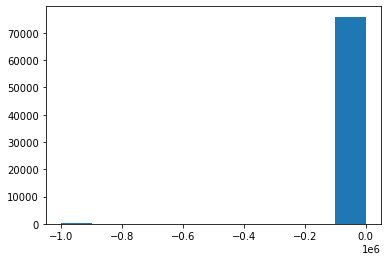

In [30]:
plt.hist(train['var3'])

In [29]:
pd.unique(train['var3'])

array([      2,     229,     178,       0,       8,       3,       4,
            10,     110,       7,     177,       1,       6,     137,
            17, -999999,      13,      14,     148,       5,      11,
            15,     122,      22,       9,      58,     121,      12,
           127,      33,     125,     209,      72,      31,      51,
            16,     107,     174,     141,     191,     104,     129,
            18,      49,      73,      94,     131,     219,     187,
           114,      28,      89,     115,      53,     126,      47,
            84,     235,     161,     197,      23,      30,     146,
           158,     138,      26,     120,      66,     216,     215,
            90,      20,      21,     103,     192,     142,      29,
           163,     223,      95,      98,      38,     156,      97,
           105,     150,     183,     184,      52,      54,     220,
            25,     225,      86,     124,      27,     162,      19,
           195,     

(array([7.598e+04, 1.900e+01, 8.000e+00, 5.000e+00, 4.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([5.16375000e+03, 2.20812125e+06, 4.41107875e+06, 6.61403625e+06,
        8.81699375e+06, 1.10199513e+07, 1.32229088e+07, 1.54258663e+07,
        1.76288238e+07, 1.98317813e+07, 2.20347388e+07]),
 <BarContainer object of 10 artists>)

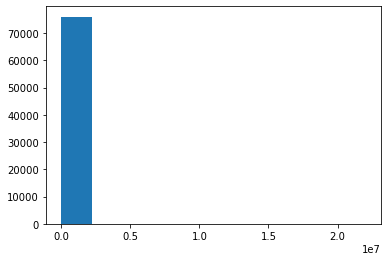

In [42]:
plt.hist(train['var38'])

(array([  948.,  7228., 12872., 11576.,  8467., 20690.,  3877.,  2649.,
         1809.,  1320.]),
 array([  5163.75 ,  27193.325,  49222.9  ,  71252.475,  93282.05 ,
        115311.625, 137341.2  , 159370.775, 181400.35 , 203429.925,
        225459.5  ]),
 <BarContainer object of 10 artists>)

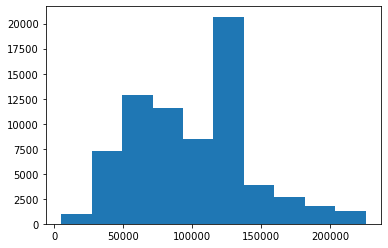

In [72]:
plt.hist(train['var38'], range=(5163.75, 225459.5))

(array([0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.4868e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([117309.7074525 , 117309.92774825, 117310.148044  , 117310.36833975,
        117310.5886355 , 117310.80893125, 117311.029227  , 117311.24952275,
        117311.4698185 , 117311.69011425, 117311.91041   ]),
 <BarContainer object of 10 artists>)

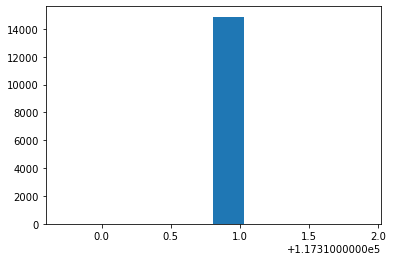

In [61]:
plt.hist(train['var38'], range=(117309.7074525, 117311.91041))

(array([  948.,  7228., 12872., 11576.,  8467.,  5821.,  3877.,  2649.,
         1809.,  1320.]),
 array([  5163.75 ,  27193.325,  49222.9  ,  71252.475,  93282.05 ,
        115311.625, 137341.2  , 159370.775, 181400.35 , 203429.925,
        225459.5  ]),
 <BarContainer object of 10 artists>)

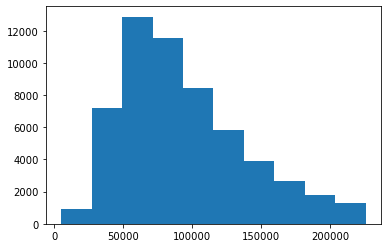

In [76]:
y = train[(train['var38'] < 117309.7074525) | (train['var38'] > 117311.91041)]['var38']
plt.hist(y, range=(5163.75, 225459.5))

(array([7.5918e+04, 5.9000e+01, 2.0000e+01, 8.0000e+00, 6.0000e+00,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([   0.   ,  823.782, 1647.564, 2471.346, 3295.128, 4118.91 ,
        4942.692, 5766.474, 6590.256, 7414.038, 8237.82 ]),
 <BarContainer object of 10 artists>)

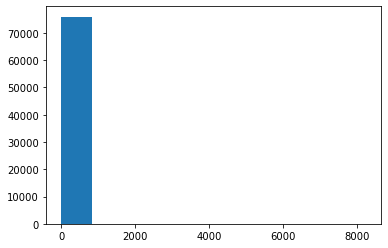

In [30]:
plt.hist(train['imp_op_var40_comer_ult1'])

(array([7.5725e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.   , 0.357, 0.714, 1.071, 1.428, 1.785, 2.142, 2.499, 2.856,
        3.213, 3.57 ]),
 <BarContainer object of 10 artists>)

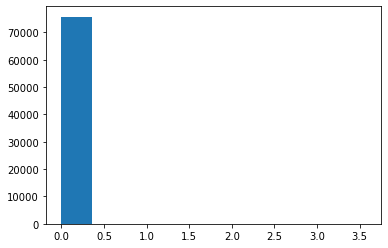

In [32]:
plt.hist(train['imp_op_var40_comer_ult1'], range=(0, 3.57))

(array([193.,  59.,  20.,   8.,   6.,   4.,   1.,   2.,   0.,   2.]),
 array([3.570000e+00, 8.269950e+02, 1.650420e+03, 2.473845e+03,
        3.297270e+03, 4.120695e+03, 4.944120e+03, 5.767545e+03,
        6.590970e+03, 7.414395e+03, 8.237820e+03]),
 <BarContainer object of 10 artists>)

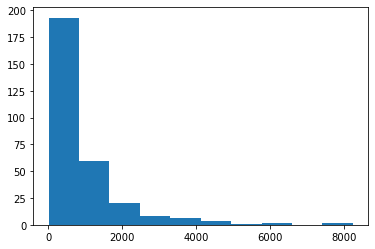

In [31]:
plt.hist(train['imp_op_var40_comer_ult1'], range=(3.57, 8.237820e+03))

#### Tiền xử lý dữ liệu

In [23]:
#xử lý các giá trị đặc biệt, thay thế nó bằng giá trị NA (-999.0)
def process_base(train, test):
    train.loc[(train['var38']>117310.979) & (train['var38']<117310.98), 'var38'] = -999.0
    test.loc[(test['var38']>117310.979) & (test['var38']<117310.98), 'var38'] = -999.0

    train.loc[train['var3']==-999999, 'var3'] = -999.0
    test.loc[test['var3']==-999999, 'var3'] = -999.0

    for f in ['imp_op_var40_comer_ult1', 'imp_op_var40_efect_ult3', 'imp_op_var41_comer_ult3', 'imp_sal_var16_ult1']:
        train.loc[train[f]==0.0, f] = -999.0
        test.loc[test[f]==0.0, f] = -999.0

    return train, test

In [24]:
#Loại bỏ các thuộc tính chỉ có 1 giá trị
def drop_sparse(train, test):
    flist = [x for x in train.columns if not x in ['ID','TARGET']]
    for f in flist:
        if len(np.unique(train[f]))<2:
            train.drop(f, axis=1, inplace=True)
            test.drop(f, axis=1, inplace=True)
    return train, test

In [25]:
def drop_duplicated(train, test):    
    #Loại bỏ var6 vì nó trùng với var29
    flist = [x for x in train.columns if not x in ['ID','TARGET']]            
    train.drop([x for x in flist if 'var6' in x], axis=1, inplace=True)
    test.drop([x for x in flist if 'var6' in x], axis=1, inplace=True)

    #Loại bỏ các thuộc tính có chứa _0 vì nó bị trùng với cột có chứa _1 theo ngay sau
    flist = [x for x in train.columns if not x in ['ID','TARGET']]        
    flist_remove = []
    for i in range(len(flist)-1):
        v = train[flist[i]].values
        for j in range(i+1, len(flist)):
            if np.array_equal(v, train[flist[j]].values):
                if '_0' in flist[j]:
                    flist_remove.append(flist[j])
                elif  '_0' in flist[i]:
                    flist_remove.append(flist[i])
    train.drop(flist_remove, axis=1, inplace=True)
    test.drop(flist_remove, axis=1, inplace=True)

    #Loại bỏ các cột bị trùng khác
    flist_remove = ['saldo_medio_var13_medio_ult1', 'delta_imp_reemb_var13_1y3', 'delta_imp_reemb_var17_1y3', 
                       'delta_imp_reemb_var33_1y3', 'delta_imp_trasp_var17_in_1y3', 'delta_imp_trasp_var17_out_1y3',
                       'delta_imp_trasp_var33_in_1y3', 'delta_imp_trasp_var33_out_1y3']
    train.drop(flist_remove, axis=1, inplace=True)
    test.drop(flist_remove, axis=1, inplace=True)
    
    return train, test

In [10]:
#Chuẩn hóa các giá trị thuộc tính
def normalize_features(train, test):
    flist = [x for x in train.columns if not x in ['ID','TARGET']]
    for f in flist:
        if train[f].max() == 9999999999.0:
            fmax = train.loc[train[f]<9999999999.0, f].max()
            train.loc[train[f]==9999999999.0, f] = fmax + 1

        if len(train.loc[train[f]<0, f].value_counts()) == 1:
            train.loc[train[f]<0, f] = -1.0
            test.loc[test[f]<0, f] = -1.0
            fmax = max(np.max(train[f]), np.max(test[f]))
            if fmax > 0:
                train.loc[train[f]>0, f] = 1.0*train.loc[train[f]>0, f]/fmax
                test.loc[test[f]>0, f] = 1.0*test.loc[test[f]>0, f]/fmax

        if len(train.loc[train[f]<0, f]) == 0:
            fmax = max(np.max(train[f]), np.max(test[f]))
            if fmax > 0:
                train.loc[train[f]>0, f] = 1.0*train.loc[train[f]>0, f]/fmax
                test.loc[test[f]>0, f] = 1.0*test.loc[test[f]>0, f]/fmax

        if len(train.loc[train[f]<0, f].value_counts()) > 1:
            fmax = max(np.max(train[f]), np.max(test[f]))
            if fmax > 0:
                train[f] = 1.0*train[f]/fmax
                test[f] = 1.0*test[f]/fmax

    return train, test

#### Feature Engineering

In [51]:
#thuộc tính t_SNE
np.random.seed(12324)
train_tsne, test_tsne = add_features(train, test, ['SumZeros'])

flist = [x for x in train_tsne.columns if not x in ['ID','TARGET']]

X = train_tsne[flist].append(test_tsne[flist], ignore_index=True).values.astype('float64')
svd = TruncatedSVD(n_components=30)
X_svd = svd.fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_svd)
feats_tsne = TSNE(n_components=2, random_state=0).fit_transform(X_scaled)
feats_tsne = pd.DataFrame(feats_tsne, columns=['tsne1', 'tsne2'])
feats_tsne['ID'] = train_tsne[['ID']].append(test_tsne[['ID']], ignore_index=True)['ID'].values
train_tsne = pd.merge(train_tsne, feats_tsne, on='ID', how='left')
test_tsne = pd.merge(test_tsne, feats_tsne, on='ID', how='left')

feat = train_tsne[['ID', 'tsne1', 'tsne2']].append(test_tsne[['ID', 'tsne1', 'tsne2']], ignore_index=True)
feat.to_csv(OUTPUT_PATH + 'tsne_feats.csv', index=False)

In [62]:
#thuộc tính PCA
train_pca, test_pca = add_features(train, test, ['SumZeros'])

flist = [x for x in train_pca.columns if not x in ['ID','TARGET']]

pca = PCA(n_components=2)
x_train_projected = pca.fit_transform(normalize(train_pca[flist], axis=0))
x_test_projected = pca.transform(normalize(test_pca[flist], axis=0))
train_pca.insert(1, 'PCAOne', x_train_projected[:, 0])
train_pca.insert(1, 'PCATwo', x_train_projected[:, 1])
test_pca.insert(1, 'PCAOne', x_test_projected[:, 0])
test_pca.insert(1, 'PCATwo', x_test_projected[:, 1])
pca_feats = train_pca[['ID', 'PCAOne', 'PCATwo']].append(test_pca[['ID', 'PCAOne', 'PCATwo']], ignore_index=True)
pca_feats.to_csv(OUTPUT_PATH + 'dmitry_pca_feats.csv')

In [81]:
#thuộc tính k-means
train_k, test_k = add_features(train, test, ['SumZeros'])
train_k, test_k = normalize_features(train_k, test_k)

flist = [x for x in train_k.columns if not x in ['ID','TARGET']]

flist_kmeans = []
for ncl in range(2,11):
    cls = KMeans(n_clusters=ncl)
    cls.fit_predict(train_k[flist].values)
    train_k['kmeans_cluster'+str(ncl)] = cls.predict(train_k[flist].values)
    test_k['kmeans_cluster'+str(ncl)] = cls.predict(test_k[flist].values)
    flist_kmeans.append('kmeans_cluster'+str(ncl))

train[['ID']+flist_kmeans].append(test[['ID']+flist_kmeans], ignore_index=True).to_csv(OUTPUT_PATH + 'kmeans_feats.csv', index=False)

In [11]:
#LL = (30.yTB + yG)/(30 + |G|)
def add_likelihood_feature(fname, train_likeli, test_likeli, flist):
    tt_likeli = pd.DataFrame()
    np.random.seed(1232345)
    #Chia fold để tính toán các giá trị
    #Tập test được điền theo tập train
    skf = StratifiedKFold(train_likeli['TARGET'].values, n_folds=5, shuffle=True, random_state=21387)
    for train_index, test_index in skf:
        ids = train_likeli['ID'].values[train_index]
        train_fold = train_likeli.loc[train_likeli['ID'].isin(ids)].copy()
        test_fold = train_likeli.loc[~train_likeli['ID'].isin(ids)].copy()
        global_avg = np.mean(train_fold['TARGET'].values)
        feats_likeli = train_fold.groupby(fname)['TARGET'].agg({'sum': np.sum, 'count': len}).reset_index()
        feats_likeli[fname + '_likeli'] = (feats_likeli['sum'] + 30.0*global_avg)/(feats_likeli['count']+30.0)
        test_fold = pd.merge(test_fold, feats_likeli[[fname, fname + '_likeli']], on=fname, how='left')
        test_fold[fname + '_likeli'] = test_fold[fname + '_likeli'].fillna(global_avg)
        tt_likeli = tt_likeli.append(test_fold[['ID', fname + '_likeli']], ignore_index=True)
    train_likeli = pd.merge(train_likeli, tt_likeli, on='ID', how='left')
    
    global_avg = np.mean(train_likeli['TARGET'].values)
    feats_likeli = train_likeli.groupby(fname)['TARGET'].agg({'sum': np.sum, 'count': len}).reset_index()
    feats_likeli[fname + '_likeli'] = (feats_likeli['sum'] + 30.0*global_avg)/(feats_likeli['count']+30.0)
    test_likeli = pd.merge(test_likeli, feats_likeli[[fname, fname + '_likeli']], on=fname, how='left')
    test_likeli[fname + '_likeli'] = test_likeli[fname + '_likeli'].fillna(global_avg)
    return train_likeli, test_likeli, flist + [fname + '_likeli']

In [12]:
def add_features(train, test, features):
    flist = [x for x in train.columns if not x in ['ID','TARGET']]
    if 'SumZeros' in features:
        train.insert(1, 'SumZeros', (train[flist] == 0).astype(int).sum(axis=1))
        test.insert(1, 'SumZeros', (test[flist] == 0).astype(int).sum(axis=1))
    flist = [x for x in train.columns if not x in ['ID','TARGET']]

    if 'tsne' in features:
        tsne_feats = pd.read_csv(OUTPUT_PATH + 'features/tsne_feats.csv')
        train = pd.merge(train, tsne_feats, on='ID', how='left')
        test = pd.merge(test, tsne_feats, on='ID', how='left')

    if 'pca' in features:
        pca_feats = pd.read_csv(OUTPUT_PATH + 'features/dmitry_pca_feats.csv')
        train = pd.merge(train, pca_feats, on='ID', how='left')
        test = pd.merge(test, pca_feats, on='ID', how='left')

    if 'kmeans' in features:
        kmeans_feats = pd.read_csv(OUTPUT_PATH + 'features/kmeans_feats.csv')
        train = pd.merge(train, kmeans_feats, on='ID', how='left')
        test = pd.merge(test, kmeans_feats, on='ID', how='left')

    return train, test

#### Mô hình

#####  FTRL2 (Follow the Regularized Leader)
Sử dụng dữ liệu gốc, Sumzeros và Likelihood

In [13]:
def train_predict_ftrl(X_train, y_train, X_test):
    train_file = '../data/output-ftrl/train_ftrl.csv'
    test_file = '../data/output-ftrl/test_ftrl.csv'
    pred_file = '../data/output-ftrl/pred_ftrl.csv'

    train_csv = pd.DataFrame(X_train)
    train_csv['TARGET'] = y_train
    train_csv['ID'] = [x for x in range(1, len(train_csv)+1)]
    train_csv.to_csv(train_file, index=False)

    test_csv = pd.DataFrame(X_test)
    test_csv['ID'] = [x for x in range(1, len(test_csv)+1)]
    test_csv.to_csv(test_file, index=False)

    non_factor_cols = "''"
    non_feature_cols = "''"
    text_cols = "''"

    os.system('pypy ftrl.py' +
              ' --alpha ' + str(0.06) +
              ' --beta ' + str(1.0) +
              ' --L1 ' + str(0.01) +
              ' --L2 ' + str(1.0) +
              ' --epoch ' + str(3) +
              ' --train ' + train_file +
              ' --test ' + test_file +
              ' --submission ' + pred_file +
              ' --non_feature_cols ' + non_feature_cols +
              ' --non_factor_cols ' + non_factor_cols + 
              ' --text_cols ' + text_cols)

    y_pred = pd.read_csv(pred_file)['PRED'].values
    filelist = glob.glob("../data/output-ftrl/*.*")
    for f in filelist:
        os.remove(f)
    return y_pred

#####  Regularized Greedy Forest
Sử dụng dữ liệu gốc, Sumzeros, PCA và Likelihood

In [14]:
def train_predict_rgf(X_train, y_train, X_test):
    clf = RGFRegressor(working_directory='../data/output-rgf/', 
                       rgf_bin = '../rgf1.2/bin/', 
                       loss = "LS",
                       reg_L2 = 0.5,
                       reg_sL2 = 0.1,
                       test_interval=500, 
                       max_leaf_forest=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_many(X_test)[-1][1]
    clf.clean_files()
    return y_pred

#####  Adaboost classifier
Sử dụng dữ liệu gốc, Sumzeros, PCA và Likelihood

In [15]:
def train_predict_adaboost_classifier(X_train, y_train, X_test):
    clf = AdaBoostClassifier(n_estimators=300, learning_rate=0.1, random_state=32934)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    return y_pred

#####  XGBOOST
Sử dụng dữ liệu gốc, Sumzeros, PCA và Likelihood

In [17]:
def train_predict_xgboost_bugged(X_train, y_train, X_test):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.02
    param['max_depth'] = 5
    param['eval_metric'] = 'auc'
    param['silent'] = 1
    param['nthread'] = 6
    param['gamma'] = 1.0
    param['min_child_weight'] = 5
    param['subsample'] = 0.8
    param['colsample_bytree'] = 1.0
    param['colsample_bylevel'] = 0.7
    num_round = 500

    y_pred = [0.0]*len(X_test)
    for seed in [123089, 21324, 324003, 450453, 120032]:
        param['seed'] = seed
        plst = list(param.items())
        xgmat_train = xgb.DMatrix(X_train, label=y_train, missing = -999.0)
        xgmat_test = xgb.DMatrix(X_test, missing = -999.0)
        bst = xgb.train(plst, xgmat_train, num_round)
        y_pred = y_pred + bst.predict( xgmat_test )
    y_pred = y_pred/5.0
    return y_pred

#### Chạy main

In [20]:
#Khai báo các models và các features tương ứng
MODELS_ALL = ['ftrl2', 'rgf3', 'rgf5', 'rgf6', 'adaboost_classifier', 'xgboost']
FEATURES_ALL = [['SumZeros', 'likeli'], 
                ['SumZeros', 'pca', 'likeli'], 
                ['SumZeros', 'tsne', 'likeli'], 
                ['SumZeros', 'kmeans', 'likeli'], 
                ['SumZeros', 'pca', 'likeli'],
                ['SumZeros', 'pca', 'likeli']]

In [ ]:
preds_all = train[['ID']].append(test[['ID']], ignore_index=True).copy()
for imod in range(len(MODELS_ALL)):
    MODEL = MODELS_ALL[imod]
    FEATURES = FEATURES_ALL[imod]
    print 'Training ' + MODEL + '...'

    train = pd.read_csv(INPUT_PATH + 'train.csv')
    test = pd.read_csv(INPUT_PATH + 'test.csv')
    id_fold = pd.read_csv(INPUT_PATH+'5fold_20times.csv')
    id_fold['ID'] = train['ID'].values

    train, test = process_base(train, test)
    train, test = drop_sparse(train, test)
    train, test = drop_duplicated(train, test)
    train, test = add_features(train, test, FEATURES)

    flist = [x for x in train.columns if not x in ['ID','TARGET']]

    preds_model = pd.DataFrame()
    for it in range(1, 21):
        print 'Processing iteration ' + str(it) + '...'   
        it_id_fold = id_fold[['ID', 'set'+str(it)]]
        it_id_fold.columns = ['ID', 'FOLD']
        if 'FOLD' in train.columns:
            train.drop('FOLD', axis=1, inplace=True)
        train = pd.merge(train, it_id_fold, on='ID', how='left')
        aucs = []
        for fold in range(5):
            train_split = train.query('FOLD != @fold').copy().reset_index(drop=True)
            y_train = train_split['TARGET'].values
            val_split = train.query('FOLD == @fold').copy().reset_index(drop=True)
            test_split = val_split[['ID']+flist].append(test[['ID']+flist], ignore_index=True)
            ids_val = val_split['ID'].values

            if 'likeli' in FEATURES:
                train_split, test_split, flist1 = add_likelihood_feature('saldo_var13', train_split, test_split, flist)
            else:
                flist1 = flist
            
            X_train = train_split[flist1].values
            y_train = train_split['TARGET'].values
            X_test = test_split[flist1].values

            if 'rgf' in MODEL:
                y_pred = train_predict_rgf(X_train, y_train, X_test)

            if MODEL == 'extra_trees':
                y_pred = train_predict_extra_trees(X_train, y_train, X_test)

            if MODEL == 'xgboost':
                y_pred = train_predict_xgboost_bugged(X_train, y_train, X_test)            

            if MODEL == 'adaboost_classifier':
                y_pred = train_predict_adaboost_classifier(X_train, y_train, X_test)

            if 'ftrl' in MODEL:
                y_pred = train_predict_ftrl(X_train, y_train, X_test)
            
            preds = pd.DataFrame()
            preds['ID'] = test_split['ID'].values
            preds['FOLD'] = fold
            preds['ITER'] = it
            preds[MODEL] = y_pred
            preds_model = preds_model.append(preds, ignore_index=True)

            preds = preds.loc[preds['ID'].isin(ids_val)].copy()
            preds = pd.merge(preds, train[['ID', 'TARGET']], on='ID', how='left')

            fold_auc = auc(preds['TARGET'], preds[MODEL])
            aucs.append(fold_auc)
        print np.mean(aucs), np.std(aucs)

    preds_model.loc[preds_model[MODEL]<0, MODEL] = 0.0
    preds_model.loc[preds_model[MODEL]>1, MODEL] = 1.0
    preds_model = preds_model.groupby(['ID', 'ITER'])[MODEL].mean().reset_index()
    for it in range(1, 21):
        preds_model.loc[preds_model['ITER']==it, MODEL] = preds_model.loc[preds_model['ITER']==it, MODEL].rank()
    preds_model = preds_model.groupby('ID')[MODEL].mean().reset_index()
    preds_model.columns = ['ID', 'dmitry_'+MODEL]
    preds_all = pd.merge(preds_all, preds_model, on='ID', how='left')
    preds_all.to_csv('all_models_temp.csv', index=False)

In [ ]:
preds_train = pd.merge(train[['ID']], preds_all, on='ID', how='left')
preds_train.to_csv(OUTPUT_PATH + 'train/' + 'dmitry_train.csv', index=False)
preds_test = pd.merge(test[['ID']], preds_all, on='ID', how='left')
preds_test.to_csv(OUTPUT_PATH + 'test/' + 'dmitry_test.csv', index=False)
print "Done training!"

### Nhóm mô hình Ikki Tanaka

#### Tiền xử lý dữ liệu

In [2]:
ori_train = pd.read_csv('train.csv')
ori_test = pd.read_csv('test.csv')
sample_submit = pd.read_csv('sample_submission.csv')

In [3]:
ori_train['target'] = ori_train['TARGET']
ori_train['t_id'] = ori_train["ID"]
ori_test['t_id'] = ori_test["ID"]

del ori_train['TARGET'], ori_train["ID"], ori_test["ID"]

In [4]:
def cleaning_rfe(ori_train, ori_test):
    print('cleaning...')
    # bad features for delete such as A = {1,2,3} * B, 
    bad = ['num_var6_0', 'num_var6', 'num_var8', 'num_var13_medio_0', 'num_var13_medio', 'num_var18_0', 'num_var18', 'num_var20_0', 'num_var20', 'num_var29_0', 'num_var29', 'num_var34_0', 'num_var34', 'num_var44', 'delta_imp_amort_var18_1y3', 'delta_imp_amort_var34_1y3', 'num_var7_emit_ult1', 'num_meses_var13_medio_ult3']

    for i in bad:
        del ori_train[i], ori_test[i]
    assert( all(ori_train.columns == ori_test.columns))

    
    # Dataframe for saving
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()


    # temporal information?
    # (ori_train[['num_var45_hace3','num_var45_hace2','num_var45_ult1']] + 1).T.pct_change().T
    tinfo = [
            ['num_op_var40_hace3','num_op_var40_hace2','num_op_var40_ult1','num_op_var40_ult3'],
            ['num_op_var41_hace3','num_op_var41_hace2','num_op_var41_ult1','num_op_var41_ult3'],
            ['num_var22_hace3', 'num_var22_hace2', 'num_var22_ult1', 'num_var22_ult3'],
            ['num_var45_hace3', 'num_var45_hace2', 'num_var45_ult1', 'num_var45_ult3'],
            ]

    #pct_change and sub
    for i in tinfo:
        a_tr = (ori_train[i] + 0.01).T.pct_change().T.iloc[:,1:]
        a_tr.columns += '_pct_change'
        a_te = (ori_test[i] + 0.01).T.pct_change().T.iloc[:,1:]
        a_te.columns += '_pct_change'
        train_df = pd.concat([train_df, a_tr], axis=1)
        test_df = pd.concat([test_df, a_te], axis=1)
        #sub
        train_df['{}-{}'.format(i[3],i[2])] = ori_train[i[3]] - ori_train[i[2]]
        train_df['{}-{}'.format(i[3],i[1])] = ori_train[i[3]] - ori_train[i[1]]
        train_df['{}-{}'.format(i[3],i[0])] = ori_train[i[3]] - ori_train[i[0]]
        test_df['{}-{}'.format(i[3],i[2])] = ori_test[i[3]] - ori_test[i[2]]
        test_df['{}-{}'.format(i[3],i[1])] = ori_test[i[3]] - ori_test[i[1]]
        test_df['{}-{}'.format(i[3],i[0])] = ori_test[i[3]] - ori_test[i[0]]
    assert( all(train_df.columns == test_df.columns))



    # comer
    comer = [
            ['imp_op_var39_comer_ult1','imp_op_var40_comer_ult1','imp_op_var41_comer_ult1'],
            ['imp_op_var39_comer_ult3','imp_op_var40_comer_ult3','imp_op_var41_comer_ult3'],
            ['num_op_var39_comer_ult1','num_op_var40_comer_ult1','num_op_var41_comer_ult1'],
            ['num_op_var39_comer_ult3','num_op_var40_comer_ult3','num_op_var41_comer_ult3'],
            ]

    def percent_row(data):
        #print data
        lhs = data.index[0]
        sum_ = data[1:].sum()
        data.index += '_pct_imp_op_' + lhs
        return pd.Series(data[1:])/(sum_+0.1)

    for i in xrange(len(comer)):
        train_df = pd.concat([train_df, ori_train[comer[i]].apply(percent_row, axis=1)],axis=1)
        test_df = pd.concat([test_df, ori_test[comer[i]].apply(percent_row, axis=1)],axis=1)
    assert( all(train_df.columns == test_df.columns))



    # efect
    efect = [
            ['imp_op_var39_efect_ult1','imp_op_var40_efect_ult1','imp_op_var41_efect_ult1'],
            ['imp_op_var39_efect_ult3','imp_op_var40_efect_ult3','imp_op_var41_efect_ult3'],
            ['num_op_var39_efect_ult1','num_op_var40_efect_ult1','num_op_var41_efect_ult1'],
            ['num_op_var39_efect_ult3','num_op_var40_efect_ult3','num_op_var41_efect_ult3'],
            ]

    def percent_row(data):
        #print data
        lhs = data.index[0]
        sum_ = data[1:].sum()
        data.index += '_pct_imp_op_' + lhs
        return pd.Series(data[1:])/(sum_+0.1)

    for i in xrange(len(efect)):
        train_df = pd.concat([train_df, ori_train[efect[i]].apply(percent_row, axis=1)],axis=1)
        test_df = pd.concat([test_df, ori_test[efect[i]].apply(percent_row, axis=1)],axis=1)
    assert( all(train_df.columns == test_df.columns))



    # imp_op
    imp_op = [['imp_op_var39_ult1','imp_op_var40_ult1','imp_op_var41_ult1']]

    def percent_row(data):
        #print data
        lhs = data.index[0]
        sum_ = data[1:].sum()
        data.index += '_pct_imp_op_' + lhs
        return pd.Series(data[1:])/(sum_+0.1)

    for i in xrange(len(imp_op)):
        train_df = pd.concat([train_df, ori_train[imp_op[i]].apply(percent_row, axis=1)],axis=1)
        test_df = pd.concat([test_df, ori_test[imp_op[i]].apply(percent_row, axis=1)],axis=1)
    assert( all(train_df.columns == test_df.columns))



    # num_op
    num_op = [
            ['num_op_var39_hace2','num_op_var40_hace2','num_op_var41_hace2'],
            ['num_op_var39_hace3','num_op_var40_hace3','num_op_var41_hace3'],
            ['num_op_var39_ult1','num_op_var40_ult1','num_op_var41_ult1'],
            ['num_op_var39_ult3','num_op_var40_ult1','num_op_var40_hace2','num_op_var40_hace3','num_op_var41_ult1','num_op_var41_hace2','num_op_var41_hace3'],
            ]

    def percent_row(data):
        #print data
        lhs = data.index[0]
        sum_ = data[1:].sum()
        data.index += '_pct_num_op_' + lhs
        return pd.Series(data[1:])/(sum_+0.1)

    for i in xrange(len(num_op)):
        train_df = pd.concat([train_df, ori_train[num_op[i]].apply(percent_row, axis=1)], axis=1)
        test_df = pd.concat([test_df, ori_test[num_op[i]].apply(percent_row, axis=1)], axis=1)
    assert( all(train_df.columns == test_df.columns))


    #make features of var39, var40, and var41
    varl = ['var39', 'var40', 'var41']
    for i in varl:
        #train
        #imp_op_var39_ult1
        train_df['imp_op_{}_efect_ult1/imp_op_{}_ult1'.format(i,i)] = ori_train['imp_op_{}_efect_ult1'.format(i)] / (ori_train['imp_op_{}_ult1'.format(i)] + 0.01)
        train_df['imp_op_{}_comer_ult1/imp_op_{}_ult1'.format(i,i)] = ori_train['imp_op_{}_comer_ult1'.format(i)] / (ori_train['imp_op_{}_ult1'.format(i)] + 0.01)
        train_df['imp_op_{}_efect_ult1/imp_op_{}_comer_ult1'.format(i,i)] = ori_train['imp_op_{}_efect_ult1'.format(i)] / (ori_train['imp_op_{}_comer_ult1'.format(i)] + 0.01)

        #train_df['imp_op_{}_efect_ult3/imp_op_{}_ult3'.format(i,i)] = ori_train['imp_op_{}_efect_ult3'.format(i)] / (ori_train['imp_op_{}_ult3'.format(i)] + 0.01)
        #train_df['imp_op_{}_comer_ult3/imp_op_{}_ult3'.format(i,i)] = ori_train['imp_op_{}_comer_ult3'.format(i)] / (ori_train['imp_op_{}_ult3'.format(i)] + 0.01)
        train_df['imp_op_{}_efect_ult3/imp_op_{}_comer_ult3'.format(i,i)] = ori_train['imp_op_{}_efect_ult3'.format(i)] / (ori_train['imp_op_{}_comer_ult3'.format(i)] + 0.01)

        #num_op_var39_ult1
        train_df['num_op_{}_efect_ult1/num_op_{}_ult1'.format(i,i)] = ori_train['num_op_{}_efect_ult1'.format(i)] / (ori_train['num_op_{}_ult1'.format(i)] + 0.01)
        train_df['num_op_{}_comer_ult1/num_op_{}_ult1'.format(i,i)] = ori_train['num_op_{}_comer_ult1'.format(i)] / (ori_train['num_op_{}_ult1'.format(i)] + 0.01)
        train_df['num_op_{}_efect_ult1/num_op_{}_comer_ult1'.format(i,i)] = ori_train['num_op_{}_efect_ult1'.format(i)] / (ori_train['num_op_{}_comer_ult1'.format(i)] + 0.01)

        train_df['num_op_{}_efect_ult3/num_op_{}_ult3'.format(i,i)] = ori_train['num_op_{}_efect_ult3'.format(i)] / (ori_train['num_op_{}_ult3'.format(i)] + 0.01)
        train_df['num_op_{}_comer_ult3/num_op_{}_ult3'.format(i,i)] = ori_train['num_op_{}_comer_ult3'.format(i)] / (ori_train['num_op_{}_ult3'.format(i)] + 0.01)
        train_df['num_op_{}_efect_ult3/num_op_{}_comer_ult3'.format(i,i)] = ori_train['num_op_{}_efect_ult3'.format(i)] / (ori_train['num_op_{}_comer_ult3'.format(i)] + 0.01)

        #num/imp_op_var39_ult1
        train_df['imp_op_{}_efect_ult1/num_op_{}_ult1'.format(i,i)] = ori_train['imp_op_{}_efect_ult1'.format(i)] / (ori_train['num_op_{}_ult1'.format(i)] + 0.01)
        train_df['imp_op_{}_comer_ult1/num_op_{}_ult1'.format(i,i)] = ori_train['imp_op_{}_comer_ult1'.format(i)] / (ori_train['num_op_{}_ult1'.format(i)] + 0.01)
        train_df['imp_op_{}_efect_ult1/num_op_{}_comer_ult1'.format(i,i)] = ori_train['imp_op_{}_efect_ult1'.format(i)] / (ori_train['num_op_{}_comer_ult1'.format(i)] + 0.01)

        train_df['imp_op_{}_efect_ult3/num_op_{}_ult3'.format(i,i)] = ori_train['imp_op_{}_efect_ult3'.format(i)] / (ori_train['num_op_{}_ult3'.format(i)] + 0.01)
        train_df['imp_op_{}_comer_ult3/num_op_{}_ult3'.format(i,i)] = ori_train['imp_op_{}_comer_ult3'.format(i)] / (ori_train['num_op_{}_ult3'.format(i)] + 0.01)
        train_df['imp_op_{}_efect_ult3/num_op_{}_comer_ult3'.format(i,i)] = ori_train['imp_op_{}_efect_ult3'.format(i)] / (ori_train['num_op_{}_comer_ult3'.format(i)] + 0.01)

        #test
        #imp_op_var39_ult1
        test_df['imp_op_{}_efect_ult1/imp_op_{}_ult1'.format(i,i)] = ori_test['imp_op_{}_efect_ult1'.format(i)] / (ori_test['imp_op_{}_ult1'.format(i)] + 0.01)
        test_df['imp_op_{}_comer_ult1/imp_op_{}_ult1'.format(i,i)] = ori_test['imp_op_{}_comer_ult1'.format(i)] / (ori_test['imp_op_{}_ult1'.format(i)] + 0.01)
        test_df['imp_op_{}_efect_ult1/imp_op_{}_comer_ult1'.format(i,i)] = ori_test['imp_op_{}_efect_ult1'.format(i)] / (ori_test['imp_op_{}_comer_ult1'.format(i)] + 0.01)

        #test_df['imp_op_{}_efect_ult3/imp_op_{}_ult3'.format(i,i)] = ori_test['imp_op_{}_efect_ult3'.format(i)] / (ori_test['imp_op_{}_ult3'.format(i)] + 0.01)
        #test_df['imp_op_{}_comer_ult3/imp_op_{}_ult3'.format(i,i)] = ori_test['imp_op_{}_comer_ult3'.format(i)] / (ori_test['imp_op_{}_ult3'.format(i)] + 0.01)
        test_df['imp_op_{}_efect_ult3/imp_op_{}_comer_ult3'.format(i,i)] = ori_test['imp_op_{}_efect_ult3'.format(i)] / (ori_test['imp_op_{}_comer_ult3'.format(i)] + 0.01)

        #num_op_var39_ult1
        test_df['num_op_{}_efect_ult1/num_op_{}_ult1'.format(i,i)] = ori_test['num_op_{}_efect_ult1'.format(i)] / (ori_test['num_op_{}_ult1'.format(i)] + 0.01)
        test_df['num_op_{}_comer_ult1/num_op_{}_ult1'.format(i,i)] = ori_test['num_op_{}_comer_ult1'.format(i)] / (ori_test['num_op_{}_ult1'.format(i)] + 0.01)
        test_df['num_op_{}_efect_ult1/num_op_{}_comer_ult1'.format(i,i)] = ori_test['num_op_{}_efect_ult1'.format(i)] / (ori_test['num_op_{}_comer_ult1'.format(i)] + 0.01)

        test_df['num_op_{}_efect_ult3/num_op_{}_ult3'.format(i,i)] = ori_test['num_op_{}_efect_ult3'.format(i)] / (ori_test['num_op_{}_ult3'.format(i)] + 0.01)
        test_df['num_op_{}_comer_ult3/num_op_{}_ult3'.format(i,i)] = ori_test['num_op_{}_comer_ult3'.format(i)] / (ori_test['num_op_{}_ult3'.format(i)] + 0.01)
        test_df['num_op_{}_efect_ult3/num_op_{}_comer_ult3'.format(i,i)] = ori_test['num_op_{}_efect_ult3'.format(i)] / (ori_test['num_op_{}_comer_ult3'.format(i)] + 0.01)

        #num/imp_op_var39_ult1
        test_df['imp_op_{}_efect_ult1/num_op_{}_ult1'.format(i,i)] = ori_train['imp_op_{}_efect_ult1'.format(i)] / (ori_train['num_op_{}_ult1'.format(i)] + 0.01)
        test_df['imp_op_{}_comer_ult1/num_op_{}_ult1'.format(i,i)] = ori_train['imp_op_{}_comer_ult1'.format(i)] / (ori_train['num_op_{}_ult1'.format(i)] + 0.01)
        test_df['imp_op_{}_efect_ult1/num_op_{}_comer_ult1'.format(i,i)] = ori_train['imp_op_{}_efect_ult1'.format(i)] / (ori_train['num_op_{}_comer_ult1'.format(i)] + 0.01)

        test_df['imp_op_{}_efect_ult3/num_op_{}_ult3'.format(i,i)] = ori_train['imp_op_{}_efect_ult3'.format(i)] / (ori_train['num_op_{}_ult3'.format(i)] + 0.01)
        test_df['imp_op_{}_comer_ult3/num_op_{}_ult3'.format(i,i)] = ori_train['imp_op_{}_comer_ult3'.format(i)] / (ori_train['num_op_{}_ult3'.format(i)] + 0.01)
        test_df['imp_op_{}_efect_ult3/num_op_{}_comer_ult3'.format(i,i)] = ori_train['imp_op_{}_efect_ult3'.format(i)] / (ori_train['num_op_{}_comer_ult3'.format(i)] + 0.01)


    assert( all(train_df.columns == test_df.columns))



    # saldo_var13 = 1 * saldo_var13_corto + 1 * saldo_var13_largo + 1 * saldo_var13_medio #
    saldo = [
            ['saldo_var13','saldo_var13_corto','saldo_var13_medio','saldo_var13_largo'],
            ]

    def percent_row(data):
        #print data
        lhs = data.index[0]
        sum_ = data.sum()
        data.index += '_pct_saldo_' + lhs 
        return pd.Series(data)/(sum_+0.1)

    train_df = pd.concat([train_df, ori_train[saldo[0]].apply(percent_row, axis=1)],axis=1)
    test_df = pd.concat([test_df, ori_test[saldo[0]].apply(percent_row, axis=1)],axis=1)
    assert( all(train_df.columns == test_df.columns))



    #num_var
    num_var = [
            ['num_var13_0','num_var13_corto_0','ind_var13_medio_0','num_var13_largo_0'],
            ['num_var13','num_var13_corto','ind_var13_medio','num_var13_largo'],
            ]

    def percent_row(data):
        #print data
        lhs = data.index[0]
        sum_ = data.sum()
        data.index += '_pct_num_var' + lhs
        return pd.Series(data)/(sum_+0.1)

    for i in xrange(len(num_var)):
        train_df = pd.concat([train_df, ori_train[num_var[i]].apply(percent_row, axis=1)],axis=1)
        test_df = pd.concat([test_df, ori_test[num_var[i]].apply(percent_row, axis=1)],axis=1)

    assert( all(train_df.columns == test_df.columns))

    ori_train = pd.concat([ori_train, train_df], axis=1)
    ori_test = pd.concat([ori_test, test_df], axis=1)
    

    return ori_train, ori_test





In [9]:
def main_feat(train, test, sample_submit=None):
    
    train_target = train['target']
    del train['target']

    #delete id
    del train['t_id'], test['t_id']

    # 0 count per ID
    def countZero(data):
        return np.sum(data == 0)

    train['count0'] = train.apply(countZero, axis=1)
    test['count0'] = test.apply(countZero, axis=1)

    # add count features of integer columns
    int_col = (train.dtypes == np.int64)[(train.dtypes == np.int64).values].index
    train_test = pd.concat([train,test])
    for i in int_col:
        tmp_cnt = train_test[i].value_counts()
        tmp_cnt = tmp_cnt.to_frame(name=i+'_cnt')
        tmp_cnt[i] = tmp_cnt.index
        tmp_cnt.reset_index(drop=True, inplace=True)
        train = train.reset_index().merge(tmp_cnt, how='left', on=i).sort('index').drop('index', axis=1)
        test = test.reset_index().merge(tmp_cnt, how='left', on=i).sort('index').drop('index', axis=1)
        train.reset_index(drop=True, inplace=True)
        test.reset_index(drop=True, inplace=True)
    del train_test

    ###### cleaing data using reverse feature engineering ######
    # To enable cleaning with reverse feature engineering,     #
    # comment out the next lines                               #
    ############################################################

    #print 'starting cleaning_rfe...'
    #train, test = cleaning_rfe(ori_train=train.copy(), ori_test=test.copy())
    #print 'done cleaning_rfe'

    # make dummy variables of var3 in the threshold(>=5)
    var3_cnt = train.var3.value_counts()
    #threshold is different from feat_ver407(var3_cnt>=5)
    index_var3_th = var3_cnt[(var3_cnt>=4).values].index
    train['var3_tmp'] = train.var3.apply(lambda x: x if x in index_var3_th else np.nan)
    test['var3_tmp'] = test.var3.apply(lambda x: x if x in index_var3_th else np.nan)
    
    train_test = pd.concat([train,test])
    #train_test.reset_index(drop=True, inplace=True)
    tmp = pd.get_dummies(train_test['var3_tmp'], prefix='ohe_var3', prefix_sep='_')

    train = pd.concat([train, tmp.iloc[:len(train),:]], axis=1)
    test = pd.concat([test, tmp.iloc[len(train):,:]], axis=1)
    del train['var3_tmp'], test['var3_tmp']

    # add feature of var38
    train['var38mc'] = np.isclose(train.var38, 117310.979016)
    train['logvar38'] = train.loc[~train['var38mc'], 'var38'].map(np.log)
    train.loc[train['var38mc'], 'logvar38'] = 0

    test['var38mc'] = np.isclose(test.var38, 117310.979016)
    test['logvar38'] = test.loc[~test['var38mc'], 'var38'].map(np.log)
    test.loc[test['var38mc'], 'logvar38'] = 0

    train['var38mc'] = train['var38mc'].astype(int)

    test['var38mc'] = test['var38mc'].astype(int)

    #delete constant features
    for i in train.columns:
        if len(set(train[i].values)) == 1:
            del train[i], test[i]
    assert( all(train.columns == test.columns))

    #delete identical columns
    unique_col = train.T.drop_duplicates().T.columns
    train = train[unique_col]
    test = test[unique_col]
    assert( all(train.columns == test.columns))


    train['target'] = train_target

    train.to_csv('features_train_ver2.csv',index=None)
    test.to_csv('features_test_ver2.csv',index=None)




In [10]:
 main_feat(train=ori_train.copy(), test=ori_test.copy())

Huấn luyện mô hình theo Xgboost

In [ ]:


#Genaral packages
import os, sys
import pandas as pd
import numpy as np

sys.path.append(os.getcwd())


#PATH
from base_fixed_fold import FOLDER_NAME, PATH, INPUT_PATH, OUTPUT_PATH, ORIGINAL_TRAIN_FORMAT, SUBMIT_FORMAT


np.random.seed(407)
#keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2, l1l2, activity_l2

#base_ver2 utils
from base_fixed_fold import load_data, save_pred_as_submit_format, create_cv_id


#classifiers
from base_fixed_fold import BaseModel, XGBClassifier, KerasClassifier


########### First stage ###########

# FEATURE LISTS in Stage 1.

FEATURE_LIST_stage1 = {
                'train':('data/output/features/features_train_ver2.csv',
                         'data/output/features/one_hot_encoder_train_ver1.csv',
                         
                        ),#target is in 'train'
                'test':('data/output/features/features_test_ver2.csv',
                        'data/output/features/one_hot_encoder_test_ver1.csv',
                        ),
                }




# Models in Stage 1
PARAMS_V1 = {
        'colsample_bytree':0.82,'colsample_bylevel':0.9,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':5, 'min_child_weight':1,
        'nthread':8,'gamma':1.0,'reg_lambda':5.0,'reg_alpha':0.0001,
        'objective':'binary:logistic','seed':111,
        'silent':1, 'subsample':0.60,'base_score':0.04
        }

class ModelV1(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=565)

PARAMS_V2 = {
        'colsample_bytree':0.74,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':6, 'min_child_weight':1,
        'nthread':8,'gamma':1.2,'reg_lambda':6.0,'reg_alpha':0.001,
        'objective':'binary:logistic','seed':1210,
        'silent':1, 'subsample':0.77,'base_score':0.04
        }

class ModelV2(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=595)




PARAMS_V3 = {
        'colsample_bytree':0.63,'colsample_bylevel':0.75,
        'learning_rate':0.02,"eval_metric":"auc",
        'max_depth':6, 'min_child_weight':3,
        'nthread':8,'gamma':2.5,'reg_lambda':6,'reg_alpha':0,
        'objective':'binary:logistic','seed':2323323,
        'silent':1, 'subsample':0.86,'base_score':0.04
        }

class ModelV3(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=400)



PARAMS_V4 = {
        'colsample_bytree':0.8,'colsample_bylevel':0.7,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':6, 'min_child_weight':3,
        'nthread':8,'gamma':5,'reg_lambda':1,'reg_alpha':0,
        'objective':'binary:logistic','seed':407,
        'silent':1, 'subsample':0.7,'base_score':0.04
            }

class ModelV4(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=570)


PARAMS_V5 = {
        'colsample_bytree':0.62,'colsample_bylevel':0.725,
        'learning_rate':0.015,"eval_metric":"auc",
        'max_depth':6, 'min_child_weight':2,
        'nthread':8,'gamma':2,'reg_lambda':5,'reg_alpha':0.01,
        'objective':'binary:logistic','seed':404447,
        'silent':1, 'subsample':0.76,'base_score':0.04
        }

class ModelV5(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=580)

PARAMS_V6 = {
        'colsample_bytree':0.85,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':5, 'min_child_weight':1,
        'nthread':8,'gamma':0.5,'reg_lambda':1,'reg_alpha':0.0001,
        'objective':'binary:logistic','seed':47707,
        'silent':1, 'subsample':0.736,'base_score':0.04
        }

class ModelV6(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=570)

PARAMS_V7 = {
        'colsample_bytree':0.72,'colsample_bylevel':0.8,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':5, 'min_child_weight':1,
        'nthread':8,'gamma':0.5,'reg_lambda':4.5,'reg_alpha':0.001,
        'objective':'binary:logistic','random_state':43244,
        'silent':1, 'subsample':0.70,'base_score':0.04
        }

class ModelV7(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=570)


PARAMS_V8 = {
        'colsample_bytree':0.71,'colsample_bylevel':0.82,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':6, 'min_child_weight':1,
        'nthread':8,'gamma':4,'reg_lambda':1,'reg_alpha':0,
        'objective':'binary:logistic','seed':4027,
        'silent':1, 'subsample':0.7,'base_score':0.04
            }

class ModelV8(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=570)


PARAMS_V9 = {
        'colsample_bytree':0.60,'colsample_bylevel':0.85,
        'learning_rate':0.015,"eval_metric":"auc",
        'max_depth':6, 'min_child_weight':3,
        'nthread':8,'gamma':2,'reg_lambda':8,'reg_alpha':0.01,
        'objective':'binary:logistic','seed':40723,
        'silent':1, 'subsample':0.70,'base_score':0.04
        }

class ModelV9(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=580)


PARAMS_V10 = {
        'colsample_bytree':0.62,'colsample_bylevel':0.9,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':5, 'min_child_weight':1,
        'nthread':8,'gamma':0.8,'reg_lambda':3.5,'reg_alpha':0.001,
        'objective':'binary:logistic','random_state':434,
        'silent':1, 'subsample':0.79,'base_score':0.04
        }

class ModelV10(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=570)

PARAMS_V11 = {
        'colsample_bytree':0.80,'colsample_bylevel':0.9,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':5, 'min_child_weight':1,
        'nthread':8,'gamma':1.0,'reg_lambda':5.0,'reg_alpha':0.0001,
        'objective':'binary:logistic','seed':333,
        'silent':1, 'subsample':0.50,'base_score':0.04
        }

class ModelV11(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=565)

PARAMS_V12 = {
        'colsample_bytree':0.70,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':6, 'min_child_weight':1,
        'nthread':8,'gamma':1.2,'reg_lambda':7.0,'reg_alpha':0.001,
        'objective':'binary:logistic','seed':10,
        'silent':1, 'subsample':0.75,'base_score':0.04
        }

class ModelV12(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=595)



PARAMS_V13 = {
        'colsample_bytree':0.55,'colsample_bylevel':0.85,
        'learning_rate':0.02,"eval_metric":"auc",
        'max_depth':6, 'min_child_weight':3,
        'nthread':8,'gamma':2.5,'reg_lambda':6,'reg_alpha':0.001,
        'objective':'binary:logistic','seed':232323,
        'silent':1, 'subsample':0.86,'base_score':0.04
        }

class ModelV13(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=400)


PARAMS_V14 = {
        'colsample_bytree':0.6,'colsample_bylevel':0.8,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':6, 'min_child_weight':1,
        'nthread':8,'gamma':5,'reg_lambda':1,'reg_alpha':0,
        'objective':'binary:logistic','seed':407,
        'silent':1, 'subsample':0.7,'base_score':0.04
            }

class ModelV14(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=570)


PARAMS_V15 = {
        'colsample_bytree':0.6,'colsample_bylevel':0.75,
        'learning_rate':0.015,"eval_metric":"auc",
        'max_depth':6, 'min_child_weight':3,
        'nthread':8,'gamma':2,'reg_lambda':8,'reg_alpha':0.01,
        'objective':'binary:logistic','seed':407,
        'silent':1, 'subsample':0.76,'base_score':0.04
        }

class ModelV15(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=580)

PARAMS_V16 = {
        'colsample_bytree':0.75,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':5, 'min_child_weight':1,
        'nthread':8,'gamma':0.0,'reg_lambda':1,'reg_alpha':0.0,
        'objective':'binary:logistic','seed':407,
        'silent':1, 'subsample':0.736,'base_score':0.04
        }

class ModelV16(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=570)

PARAMS_V17 = {
        'colsample_bytree':0.62,'colsample_bylevel':0.9,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':5, 'min_child_weight':1,
        'nthread':8,'gamma':0.5,'reg_lambda':4.5,'reg_alpha':0.001,
        'objective':'binary:logistic','random_state':434,
        'silent':1, 'subsample':0.80,'base_score':0.04
        }

class ModelV17(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=570)

PARAMS_V18 = {
        'colsample_bytree':0.89,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':5, 'min_child_weight':1,
        'nthread':8,'gamma':1.0,'reg_lambda':5.0,'reg_alpha':0.0001,
        'objective':'binary:logistic','seed':333,
        'silent':1, 'subsample':0.60,'base_score':0.04
        }

class ModelV18(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=565)

PARAMS_V19 = {
        'colsample_bytree':0.75,
        'learning_rate':0.01,"eval_metric":"auc",
        'max_depth':6, 'min_child_weight':1,
        'nthread':8,'gamma':1.2,'reg_lambda':7.0,'reg_alpha':0.001,
        'objective':'binary:logistic','seed':0,
        'silent':1, 'subsample':0.75,'base_score':0.04
        }

class ModelV19(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=595)




PARAMS_V20 = {
        'colsample_bytree':0.55,'colsample_bylevel':0.85,
        'learning_rate':0.02,"eval_metric":"auc",
        'max_depth':6, 'min_child_weight':3,
        'nthread':8,'gamma':2.5,'reg_lambda':6,'reg_alpha':0,
        'objective':'binary:logistic','seed':3231,
        'silent':1, 'subsample':0.86,'base_score':0.04
        }

class ModelV20(BaseModel):
        def build_model(self):
            return XGBClassifier(params=self.params, num_round=400)




if __name__ == "__main__":

    m = ModelV1(name="v1_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V1,
                kind = 's', fold_name='set1'
                )
    m.run()


    m = ModelV2(name="v2_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V2,
                kind = 's', fold_name='set2'
                )
    m.run()


    m = ModelV3(name="v3_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V3,
                kind = 's', fold_name='set3'
                )
    m.run()


    m = ModelV4(name="v4_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V4,
                kind = 's', fold_name='set4'
                )
    m.run()


    m = ModelV5(name="v5_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V5,
                kind = 's', fold_name='set5'
                )
    m.run()


    m = ModelV6(name="v6_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V6,
                kind = 's', fold_name='set6'
                )
    m.run()


    m = ModelV7(name="v7_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V7,
                kind = 's', fold_name='set7'
                )
    m.run()


    m = ModelV8(name="v8_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V8,
                kind = 's', fold_name='set8'
                )
    m.run()


    m = ModelV9(name="v9_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V9,
                kind = 's', fold_name='set9'
                )
    m.run()


    m = ModelV10(name="v10_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V10,
                kind = 's', fold_name='set10'
                )
    m.run()


    m = ModelV11(name="v11_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V11,
                kind = 's', fold_name='set11'
                )
    m.run()


    m = ModelV12(name="v12_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V12,
                kind = 's', fold_name='set12'
                )
    m.run()


    m = ModelV13(name="v13_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V13,
                kind = 's', fold_name='set13'
                )
    m.run()


    m = ModelV14(name="v14_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V14,
                kind = 's', fold_name='set14'
                )
    m.run()


    m = ModelV15(name="v15_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V15,
                kind = 's', fold_name='set15'
                )
    m.run()


    m = ModelV16(name="v16_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V16,
                kind = 's', fold_name='set16'
                )
    m.run()


    m = ModelV17(name="v17_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V17,
                kind = 's', fold_name='set17'
                )
    m.run()


    m = ModelV18(name="v18_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V18,
                kind = 's', fold_name='set18'
                )
    m.run()


    m = ModelV19(name="v19_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V19,
                kind = 's', fold_name='set19'
                )
    m.run()


    m = ModelV20(name="v20_stage1_ver2",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V20,
                kind = 's', fold_name='set20'
                )
    m.run()


    
    print ('Done stage 1')

    print ('Averaging')
    # averaging
    sample_sub = pd.read_csv('data/input/sample_submission.csv')
    testID = sample_sub[['ID']]
    a = pd.DataFrame()
    for i in ['data/output/temp/v1_stage1_ver2_test.csv',
              'data/output/temp/v2_stage1_ver2_test.csv',
              'data/output/temp/v3_stage1_ver2_test.csv',
              'data/output/temp/v4_stage1_ver2_test.csv',
              'data/output/temp/v5_stage1_ver2_test.csv',
              'data/output/temp/v6_stage1_ver2_test.csv',
              'data/output/temp/v7_stage1_ver2_test.csv',
              'data/output/temp/v8_stage1_ver2_test.csv',
              'data/output/temp/v9_stage1_ver2_test.csv',
              'data/output/temp/v10_stage1_ver2_test.csv',
              'data/output/temp/v11_stage1_ver2_test.csv',
              'data/output/temp/v12_stage1_ver2_test.csv',
              'data/output/temp/v13_stage1_ver2_test.csv',
              'data/output/temp/v14_stage1_ver2_test.csv',
              'data/output/temp/v15_stage1_ver2_test.csv',
              'data/output/temp/v16_stage1_ver2_test.csv',
              'data/output/temp/v17_stage1_ver2_test.csv',
              'data/output/temp/v18_stage1_ver2_test.csv',
              'data/output/temp/v19_stage1_ver2_test.csv',
              'data/output/temp/v20_stage1_ver2_test.csv',
              ]:
        x = pd.read_csv(i)
        a = pd.concat([a, x],axis=1)
    #x['TARGET'] = (a.rank().mean(1))/a.shape[0]
    # just averaging
    x['TARGET'] = a.mean(1)
    x = pd.concat([testID, x[['TARGET']]], axis=1)
    x.to_csv('data/output/temp/test_xgb_ikkiver2_variantA.csv', index=None)
    #pubLB: 

    # averaging
    a = pd.DataFrame()
    train = pd.read_csv('../data/input/train.csv')
    targetID = train[['ID']]
    for i in ['data/output/temp/v1_stage1_ver2_all_fold.csv',
              'data/output/temp/v2_stage1_ver2_all_fold.csv',
              'data/output/temp/v3_stage1_ver2_all_fold.csv',
              'data/output/temp/v4_stage1_ver2_all_fold.csv',
              'data/output/temp/v5_stage1_ver2_all_fold.csv',
              'data/output/temp/v6_stage1_ver2_all_fold.csv',
              'data/output/temp/v7_stage1_ver2_all_fold.csv',
              'data/output/temp/v8_stage1_ver2_all_fold.csv',
              'data/output/temp/v9_stage1_ver2_all_fold.csv',
              'data/output/temp/v10_stage1_ver2_all_fold.csv',
              'data/output/temp/v11_stage1_ver2_all_fold.csv',
              'data/output/temp/v12_stage1_ver2_all_fold.csv',
              'data/output/temp/v13_stage1_ver2_all_fold.csv',
              'data/output/temp/v14_stage1_ver2_all_fold.csv',
              'data/output/temp/v15_stage1_ver2_all_fold.csv',
              'data/output/temp/v16_stage1_ver2_all_fold.csv',
              'data/output/temp/v17_stage1_ver2_all_fold.csv',
              'data/output/temp/v18_stage1_ver2_all_fold.csv',
              'data/output/temp/v19_stage1_ver2_all_fold.csv',
              'data/output/temp/v20_stage1_ver2_all_fold.csv',
              ]:
        x = pd.read_csv(i)
        a = pd.concat([a, x],axis=1)
    #x['TARGET'] = (a.rank().mean(1))/a.shape[0]
    # just averaging
    x['TARGET'] = a.mean(1)
    x = pd.concat([targetID, x[['TARGET']]], axis=1)
    x.to_csv('data/output/temp/train_xgb_ikkiver2_variantA.csv', index=None)
    #pubLB: 
    print ('Done averaging')

    print ('rank transformation with train and test')
    #rank trafo with train and test
    tr = pd.read_csv('data/output/temp/train_xgb_ikkiver2_variantA.csv')
    te = pd.read_csv('data/output/temp/test_xgb_ikkiver2_variantA.csv')
    tr_te = pd.concat([tr, te])
    tr_te['TARGET'] = tr_te['TARGET'].rank()
    # scale [0,1]
    tr_te['TARGET'] = (tr_te['TARGET'] - tr_te['TARGET'].min()) / (tr_te['TARGET'].max() - tr_te['TARGET'].min())
    tr = tr_te.iloc[:len(tr),:]
    te = tr_te.iloc[len(tr):,:]
    tr.to_csv('data/output/temp/train_xgb_ikki_ver2.csv', index=False)
    te.to_csv('data/output/temp/test_xgb_ikki_ver2.csv', index=False)
    print ('Done rank transformation')

    print ('CV of each model per fold and averaging')
    # CV of each model and averaging
    from sklearn.metrics import roc_auc_score as AUC
    a = pd.DataFrame()
    set_idnex = 1
    set_data = pd.read_csv('../data/input/5fold_20times.csv')
    y = train.TARGET
    for i in ['data/output/temp/v1_stage1_ver2_all_fold.csv',
              'data/output/temp/v2_stage1_ver2_all_fold.csv',
              'data/output/temp/v3_stage1_ver2_all_fold.csv',
              'data/output/temp/v4_stage1_ver2_all_fold.csv',
              'data/output/temp/v5_stage1_ver2_all_fold.csv',
              'data/output/temp/v6_stage1_ver2_all_fold.csv',
              'data/output/temp/v7_stage1_ver2_all_fold.csv',
              'data/output/temp/v8_stage1_ver2_all_fold.csv',
              'data/output/temp/v9_stage1_ver2_all_fold.csv',
              'data/output/temp/v10_stage1_ver2_all_fold.csv',
              'data/output/temp/v11_stage1_ver2_all_fold.csv',
              'data/output/temp/v12_stage1_ver2_all_fold.csv',
              'data/output/temp/v13_stage1_ver2_all_fold.csv',
              'data/output/temp/v14_stage1_ver2_all_fold.csv',
              'data/output/temp/v15_stage1_ver2_all_fold.csv',
              'data/output/temp/v16_stage1_ver2_all_fold.csv',
              'data/output/temp/v17_stage1_ver2_all_fold.csv',
              'data/output/temp/v18_stage1_ver2_all_fold.csv',
              'data/output/temp/v19_stage1_ver2_all_fold.csv',
              'data/output/temp/v20_stage1_ver2_all_fold.csv',
              ]:
        x = pd.read_csv(i)
        a = pd.concat([a, x],axis=1)

        cv_index = {}
        set_name = 'set{}'.format(set_idnex)
        for i in range(5):
            train_cv = set_data.loc[(set_data[set_name]!=i).values, set_name].index
            test_cv = set_data.loc[(set_data[set_name]==i).values, set_name].index
            cv_index[i] = {}
            cv_index[i]['train'] = train_cv.values
            cv_index[i]['test'] = test_cv.values

        skf = pd.DataFrame(cv_index).stack().T
        auc = []
        for i in range(5):
            #print AUC(y.ix[skf['test'][i]].values, x.ix[skf['test'][i]].values) 
            auc.append(AUC(y.ix[skf['test'][i]].values, x.ix[skf['test'][i]].values))

        set_idnex += 1
    print ('Per model, mean: {} std: {}'.format(np.mean(auc), np.std(auc)))
    print ('Averaging AUC:{}'.format(AUC(y.values,a.mean(1).values)))

Huấn luyện với Neural Network

In [ ]:
#Genaral packages
import os, sys
import pandas as pd
import numpy as np

sys.path.append(os.getcwd())
#os.chdir('/Users/IkkiTanaka/Documents/kaggle/Santander/')

#PATH
from base_fixed_fold import FOLDER_NAME, PATH, INPUT_PATH, OUTPUT_PATH, ORIGINAL_TRAIN_FORMAT, SUBMIT_FORMAT


np.random.seed(407)
#keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2, l1l2, activity_l2

#base_ver2 utils
from base_fixed_fold import load_data, save_pred_as_submit_format, create_cv_id


#classifiers
from base_fixed_fold import BaseModel, XGBClassifier, KerasClassifier






FEATURE_LIST_stage1 = {
                'train':('data/output/features/features_train_NN_ver3.csv',
                         'data/output/features/one_hot_encoder_train_ver1.csv',
                        ),#target is in 'train'
                'test':('data/output/features/features_test_NN_ver3.csv',
                        'data/output/features/one_hot_encoder_test_ver1.csv',
                        ),
                }
X,y,test  = load_data(flist=FEATURE_LIST_stage1, drop_duplicates=True)
assert((False in X.columns == test.columns) == False)
nn_input_dim_NN = X.shape[1]
del X, y, test



# Models in Stage 1
PARAMS_V1 = {
            'batch_size':256,
            'nb_epoch':35,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV1(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.2, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=120, init='uniform'))
            model.add(LeakyReLU(alpha=.00001))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(input_dim=120,output_dim=280, init='uniform'))
            model.add(LeakyReLU(alpha=.00001))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(input_dim=280,output_dim=100, init='uniform', activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.4))
            model.add(Dense(input_dim=100,output_dim=2, init='uniform', activation='softmax'))    
            #model.add(Activation('softmax'))
            sgd = SGD(lr=0.015, decay=1e-6, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)


PARAMS_V2 = {
            'batch_size':512,
            'nb_epoch':70,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV2(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=112, init='he_normal'))
            model.add(LeakyReLU(alpha=.00001))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(input_dim=112,output_dim=128, init='he_normal'))
            model.add(LeakyReLU(alpha=.00001))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(input_dim=128,output_dim=68, init='he_normal'))
            model.add(LeakyReLU(alpha=.00003))
            model.add(BatchNormalization())
            model.add(Dropout(0.3))
            model.add(Dense(input_dim=68,output_dim=2, init='he_normal'))
            model.add(Activation('softmax'))
            sgd = SGD(lr=0.01, decay=1e-10, momentum=0.99, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)

PARAMS_V3 = {
            'batch_size':128,
            'nb_epoch':72,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV3(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=310, init='he_normal'))
            model.add(LeakyReLU(alpha=.001))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=310,output_dim=252, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(input_dim=252,output_dim=128, init='he_normal'))
            model.add(LeakyReLU(alpha=.001))
            model.add(BatchNormalization())
            model.add(Dropout(0.4))
            model.add(Dense(input_dim=128,output_dim=2, init='he_normal', activation='softmax'))
            #model.add(Activation('softmax'))
            sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)

PARAMS_V4 = {
            'batch_size':128,
            'nb_epoch':56,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV4(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=62, init='he_normal'))
            model.add(LeakyReLU(alpha=.001))
            model.add(Dropout(0.3))
            model.add(Dense(input_dim=62,output_dim=158, init='he_normal'))
            model.add(LeakyReLU(alpha=.001))
            model.add(Dropout(0.25))
            model.add(Dense(input_dim=158,output_dim=20, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=20,output_dim=2, init='he_normal', activation='softmax'))
            #model.add(Activation('softmax'))
            sgd = SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)


PARAMS_V5 = {
            'batch_size':216,
            'nb_epoch':90,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV5(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=100, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=100,output_dim=380, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=380,output_dim=50, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=50,output_dim=20, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=20,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.01, decay=1e-10, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)

PARAMS_V6 = {
            'batch_size':216,
            'nb_epoch':72,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV6(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=105, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=105,output_dim=280, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=280,output_dim=60, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=60,output_dim=20, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=20,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.01, decay=1e-10, momentum=0.99, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)

PARAMS_V7 = {
            'batch_size':128,
            'nb_epoch':65,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV7(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.2, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=100, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=100,output_dim=180, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=180,output_dim=50, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(input_dim=50,output_dim=30, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=30,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.01, decay=1e-10, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)


PARAMS_V8 = {
            'batch_size':216,
            'nb_epoch':89,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV8(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.2, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=140, init='uniform'))
            model.add(LeakyReLU(alpha=.00001))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=140,output_dim=250, init='uniform'))
            model.add(LeakyReLU(alpha=.00001))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(input_dim=250,output_dim=90, init='uniform', activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.4))
            model.add(Dense(input_dim=90,output_dim=2, init='uniform', activation='softmax'))    
            #model.add(Activation('softmax'))
            sgd = SGD(lr=0.013, decay=1e-6, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)


PARAMS_V9 = {
            'batch_size':512,
            'nb_epoch':90,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV9(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=100, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=100,output_dim=380, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=380,output_dim=50, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=50,output_dim=20, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=20,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.01, decay=1e-10, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)


PARAMS_V10 = {
            'batch_size':216,
            'nb_epoch':80,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV10(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=100, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=100,output_dim=360, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=360,output_dim=50, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=50,output_dim=20, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=20,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.01, decay=1e-10, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)


PARAMS_V11 = {
            'batch_size':384,
            'nb_epoch':80,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV11(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=110, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=110,output_dim=350, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=350,output_dim=50, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=50,output_dim=20, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=20,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.01, decay=1e-10, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)

PARAMS_V12 = {
            'batch_size':216,
            'nb_epoch':82,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV12(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=110, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.3))
            model.add(Dense(input_dim=110,output_dim=300, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(input_dim=300,output_dim=60, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=60,output_dim=20, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=20,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.01, decay=1e-10, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)

PARAMS_V13 = {
            'batch_size':512,
            'nb_epoch':90,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV13(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=100, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(Dropout(0.1))
            model.add(Dense(input_dim=100,output_dim=300, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=300,output_dim=50, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=50,output_dim=20, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=20,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.01, decay=1e-10, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)

PARAMS_V14 = {
            'batch_size':216,
            'nb_epoch':72,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV14(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=105, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=105,output_dim=200, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=200,output_dim=60, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(input_dim=60,output_dim=20, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.1))
            model.add(Dense(input_dim=20,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.01, decay=1e-10, momentum=0.99, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)

PARAMS_V15 = {
            'batch_size':128,
            'nb_epoch':65,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV15(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.2, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=100, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=100,output_dim=180, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(input_dim=180,output_dim=50, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(input_dim=50,output_dim=40, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=40,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.01, decay=1e-10, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)


PARAMS_V16 = {
            'batch_size':216,
            'nb_epoch':89,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV16(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.2, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=140, init='uniform'))
            model.add(LeakyReLU(alpha=.00001))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=140,output_dim=250, init='uniform'))
            model.add(LeakyReLU(alpha=.00001))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=250,output_dim=90, init='uniform', activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.4))
            model.add(Dense(input_dim=90,output_dim=2, init='uniform', activation='softmax'))    
            #model.add(Activation('softmax'))
            sgd = SGD(lr=0.013, decay=1e-6, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)


PARAMS_V17 = {
            'batch_size':512,
            'nb_epoch':90,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV17(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=140, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=140,output_dim=380, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=380,output_dim=50, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=50,output_dim=20, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=20,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.01, decay=1e-10, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)


PARAMS_V18 = {
            'batch_size':216,
            'nb_epoch':80,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV18(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=100, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=100,output_dim=360, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=360,output_dim=50, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=50,output_dim=20, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.1))
            model.add(Dense(input_dim=20,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.007, decay=1e-10, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)


PARAMS_V19 = {
            'batch_size':384,
            'nb_epoch':80,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV19(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=110, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=110,output_dim=350, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=350,output_dim=150, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=150,output_dim=20, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(input_dim=20,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.02, decay=1e-10, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)

PARAMS_V20 = {
            'batch_size':216,
            'nb_epoch':82,
            'verbose':1, 
            'callbacks':[],
            'validation_split':0.,
            'validation_data':None,
            'shuffle':True,
            'show_accuracy':True,
            'class_weight':None,#{0:0.0396, 1:0.9604},
            'sample_weight':None,
            'normalize':True,
            'categorize_y':True
            }

class ModelV20(BaseModel):
        def build_model(self):
            model = Sequential()
            model.add(Dropout(0.1, input_shape=(nn_input_dim_NN,)))
            model.add(Dense(input_dim=nn_input_dim_NN, output_dim=110, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.3))
            model.add(Dense(input_dim=110,output_dim=200, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(input_dim=200,output_dim=60, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.6))
            model.add(Dense(input_dim=60,output_dim=80, init='he_normal'))
            model.add(PReLU(init='zero'))
            model.add(BatchNormalization())
            model.add(Dropout(0.3))
            model.add(Dense(input_dim=80,output_dim=2, init='he_normal', activation='softmax'))    
            sgd = SGD(lr=0.01, decay=1e-10, momentum=0.9, nesterov=True)

            model.compile(optimizer=sgd, loss='binary_crossentropy',class_mode='binary')

            return KerasClassifier(nn=model,**self.params)



if __name__ == "__main__":
    
    m = ModelV1(name="v1_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V1,
                kind = 's', fold_name='set1'
                )
    m.run()


    m = ModelV2(name="v2_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V2,
                kind = 's', fold_name='set2'
                )
    m.run()


    m = ModelV3(name="v3_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V3,
                kind = 's', fold_name='set3'
                )
    m.run()


    m = ModelV4(name="v4_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V4,
                kind = 's', fold_name='set4'
                )
    m.run()


    m = ModelV5(name="v5_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V5,
                kind = 's', fold_name='set5'
                )
    m.run()


    m = ModelV6(name="v6_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V6,
                kind = 's', fold_name='set6'
                )
    m.run()


    m = ModelV7(name="v7_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V7,
                kind = 's', fold_name='set7'
                )
    m.run()


    m = ModelV8(name="v8_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V8,
                kind = 's', fold_name='set8'
                )
    m.run()


    m = ModelV9(name="v9_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V9,
                kind = 's', fold_name='set9'
                )
    m.run()
    

    m = ModelV10(name="v10_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V10,
                kind = 's', fold_name='set10'
                )
    m.run()


    m = ModelV11(name="v11_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V11,
                kind = 's', fold_name='set11'
                )
    m.run()


    m = ModelV12(name="v12_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V12,
                kind = 's', fold_name='set12'
                )
    m.run()


    m = ModelV13(name="v13_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V13,
                kind = 's', fold_name='set13'
                )
    m.run()


    m = ModelV14(name="v14_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V14,
                kind = 's', fold_name='set14'
                )
    m.run()


    m = ModelV15(name="v15_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V15,
                kind = 's', fold_name='set15'
                )
    m.run()


    m = ModelV16(name="v16_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V16,
                kind = 's', fold_name='set16'
                )
    m.run()


    m = ModelV17(name="v17_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V17,
                kind = 's', fold_name='set17'
                )
    m.run()


    m = ModelV18(name="v18_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V18,
                kind = 's', fold_name='set18'
                )
    m.run()


    m = ModelV19(name="v19_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V19,
                kind = 's', fold_name='set19'
                )
    m.run()


    m = ModelV20(name="v20_stage1_ver3",
                flist=FEATURE_LIST_stage1,
                params = PARAMS_V20,
                kind = 's', fold_name='set20'
                )
    m.run()


    
    print ('Done stage 1')

    print ('Averaging')
    # averaging
    sample_sub = pd.read_csv('data/input/sample_submission.csv')
    testID = sample_sub[['ID']]
    a = pd.DataFrame()
    for i in ['data/output/temp/v1_stage1_ver3_test.csv',
              'data/output/temp/v2_stage1_ver3_test.csv',
              'data/output/temp/v3_stage1_ver3_test.csv',
              'data/output/temp/v4_stage1_ver3_test.csv',
              'data/output/temp/v5_stage1_ver3_test.csv',
              'data/output/temp/v6_stage1_ver3_test.csv',
              'data/output/temp/v7_stage1_ver3_test.csv',
              'data/output/temp/v8_stage1_ver3_test.csv',
              'data/output/temp/v9_stage1_ver3_test.csv',
              'data/output/temp/v10_stage1_ver3_test.csv',
              'data/output/temp/v11_stage1_ver3_test.csv',
              'data/output/temp/v12_stage1_ver3_test.csv',
              'data/output/temp/v13_stage1_ver3_test.csv',
              'data/output/temp/v14_stage1_ver3_test.csv',
              'data/output/temp/v15_stage1_ver3_test.csv',
              'data/output/temp/v16_stage1_ver3_test.csv',
              'data/output/temp/v17_stage1_ver3_test.csv',
              'data/output/temp/v18_stage1_ver3_test.csv',
              'data/output/temp/v19_stage1_ver3_test.csv',
              'data/output/temp/v20_stage1_ver3_test.csv',
              ]:
        x = pd.read_csv(i)
        a = pd.concat([a, x],axis=1)
    #x['TARGET'] = (a.rank().mean(1))/a.shape[0]
    # just averaging
    x['TARGET'] = a.mean(1)
    x = pd.concat([testID, x[['TARGET']]], axis=1)
    x.to_csv('data/output/temp/test_NN_ikkiver3_variantA.csv', index=None)
    #pubLB: 


    # averaging
    a = pd.DataFrame()
    train = pd.read_csv('../data/input/train.csv')
    targetID = train[['ID']]
    for i in ['data/output/temp/v1_stage1_ver3_all_fold.csv',
              'data/output/temp/v2_stage1_ver3_all_fold.csv',
              'data/output/temp/v3_stage1_ver3_all_fold.csv',
              'data/output/temp/v4_stage1_ver3_all_fold.csv',
              'data/output/temp/v5_stage1_ver3_all_fold.csv',
              'data/output/temp/v6_stage1_ver3_all_fold.csv',
              'data/output/temp/v7_stage1_ver3_all_fold.csv',
              'data/output/temp/v8_stage1_ver3_all_fold.csv',
              'data/output/temp/v9_stage1_ver3_all_fold.csv',
              'data/output/temp/v10_stage1_ver3_all_fold.csv',
              'data/output/temp/v11_stage1_ver3_all_fold.csv',
              'data/output/temp/v12_stage1_ver3_all_fold.csv',
              'data/output/temp/v13_stage1_ver3_all_fold.csv',
              'data/output/temp/v14_stage1_ver3_all_fold.csv',
              'data/output/temp/v15_stage1_ver3_all_fold.csv',
              'data/output/temp/v16_stage1_ver3_all_fold.csv',
              'data/output/temp/v17_stage1_ver3_all_fold.csv',
              'data/output/temp/v18_stage1_ver3_all_fold.csv',
              'data/output/temp/v19_stage1_ver3_all_fold.csv',
              'data/output/temp/v20_stage1_ver3_all_fold.csv',
              ]:
        x = pd.read_csv(i)
        a = pd.concat([a, x],axis=1)
    #x['TARGET'] = (a.rank().mean(1))/a.shape[0]
    # just averaging
    x['TARGET'] = a.mean(1)
    x = pd.concat([targetID, x[['TARGET']]], axis=1)
    x.to_csv('data/output/temp/train_NN_ikkiver3_variantA.csv', index=None)
    #pubLB: 
    print ('Done averaging')

    print ('rank transformation with train and test')
    #rank trafo with train and test
    tr = pd.read_csv('data/output/temp/train_NN_ikkiver3_variantA.csv')
    te = pd.read_csv('data/output/temp/test_NN_ikkiver3_variantA.csv')
    tr_te = pd.concat([tr, te])
    tr_te['TARGET'] = tr_te['TARGET'].rank()
    # scale [0,1]
    tr_te['TARGET'] = (tr_te['TARGET'] - tr_te['TARGET'].min()) / (tr_te['TARGET'].max() - tr_te['TARGET'].min())
    tr = tr_te.iloc[:len(tr),:]
    te = tr_te.iloc[len(tr):,:]
    tr.to_csv('data/output/temp/train_NN_ikki_ver3.csv', index=False)
    te.to_csv('data/output/temp/test_NN_ikki_ver3.csv', index=False)
    print('Done rank transformation')

    print('CV of each model per fold and averaging')
    # CV of each model and averaging
    from sklearn.metrics import roc_auc_score as AUC
    a = pd.DataFrame()
    set_idnex = 1
    set_data = pd.read_csv('../data/input/5fold_20times.csv')
    y = train.TARGET
    for i in ['data/output/temp/v1_stage1_ver3_all_fold.csv',
              'data/output/temp/v2_stage1_ver3_all_fold.csv',
              'data/output/temp/v3_stage1_ver3_all_fold.csv',
              'data/output/temp/v4_stage1_ver3_all_fold.csv',
              'data/output/temp/v5_stage1_ver3_all_fold.csv',
              'data/output/temp/v6_stage1_ver3_all_fold.csv',
              'data/output/temp/v7_stage1_ver3_all_fold.csv',
              'data/output/temp/v8_stage1_ver3_all_fold.csv',
              'data/output/temp/v9_stage1_ver3_all_fold.csv',
              'data/output/temp/v10_stage1_ver3_all_fold.csv',
              'data/output/temp/v11_stage1_ver3_all_fold.csv',
              'data/output/temp/v12_stage1_ver3_all_fold.csv',
              'data/output/temp/v13_stage1_ver3_all_fold.csv',
              'data/output/temp/v14_stage1_ver3_all_fold.csv',
              'data/output/temp/v15_stage1_ver3_all_fold.csv',
              'data/output/temp/v16_stage1_ver3_all_fold.csv',
              'data/output/temp/v17_stage1_ver3_all_fold.csv',
              'data/output/temp/v18_stage1_ver3_all_fold.csv',
              'data/output/temp/v19_stage1_ver3_all_fold.csv',
              'data/output/temp/v20_stage1_ver3_all_fold.csv',
              ]:
        x = pd.read_csv(i)
        a = pd.concat([a, x],axis=1)

        cv_index = {}
        set_name = 'set{}'.format(set_idnex)
        for i in range(5):
            train_cv = set_data.loc[(set_data[set_name]!=i).values, set_name].index
            test_cv = set_data.loc[(set_data[set_name]==i).values, set_name].index
            cv_index[i] = {}
            cv_index[i]['train'] = train_cv.values
            cv_index[i]['test'] = test_cv.values

        skf = pd.DataFrame(cv_index).stack().T
        auc = []
        for i in range(5):
            #print AUC(y.ix[skf['test'][i]].values, x.ix[skf['test'][i]].values) 
            auc.append(AUC(y.ix[skf['test'][i]].values, x.ix[skf['test'][i]].values))

        set_idnex += 1
    print ('Per model, mean: {} std: {}'.format(np.mean(auc), np.std(auc)))
    print ('Averaging AUC:{}'.format(AUC(y.values,a.mean(1).values)))

#### Mô hình

### Nhóm mô hình Darius Barusauskas

#### Tiền xử lý dữ liệu

#### Mô hình

### Nhóm mô hình Marios Michailidis

#### Tiền xử lý dữ liệu

* Sử dụng lại một số kết quả tiền xử lý dữ liệu của các mô hình trước. Bao gồm loại bỏ 63 cột chỉ có một giá trị và liên quan đến các cột khác, nên không cung cấp được nhiều thông tin. Một cột được tạo mới nhằm đếm số lượng số 0 trong mỗi hàng.
* Một số bước tiền xử lý khác nhau được tiến hành trong các mô hình, bao gồm:
    1. Standard scaling đối với các mô hình tuyến tính và Neural Networks
    2. Đếm từng biến mỗi loại
    3. Tính xác suất của các biến
    4. Phân tích t-SNE, PCA và kNN
    5. Kết hợp các phương pháp trên

#### Mô hình

### Nhóm mô hình Mathias Muller

#### Tiền xử lý dữ liệu

#### Mô hình

## Tài liệu tham khảo